# Compare the tidal energy dissipation due to wave drag and linear bottom drag simulated by the tide-only 1-layer global MOM6 

JSL x6 (tuned): /g/data/nm03/lxy581/archive/tides_025_JSL_x6/

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import xesmf as xe
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

### MOM6: calculate the energy dissipation

In [2]:
def interp_u2h(var):
    ds_u = xr.Dataset(data_vars={'dissip': (('yh','xq'), var),
                                },
                      coords={'lon': (('yh', 'xq'), np.array(geolon_u)),
                              'lat': (('yh', 'xq'), np.array(geolat_u))})
    ds_h = xr.Dataset(data_vars={"lat": (('yh', 'xh'), np.array(geolat)),
                                 "lon": (('yh', 'xh'), np.array(geolon)),
                                 },
                      coords={"yh":yh, "xh":xh})
    regridder_u2h = xe.Regridder(ds_u, ds_h, "bilinear", extrap_method="inverse_dist")
    ds_h = regridder_u2h(ds_u)
    return ds_h['dissip']

In [3]:
def interp_v2h(var):
    ds_v = xr.Dataset(data_vars={'dissip': (('yq','xh'), var),
                                },
                      coords={'lon': (('yq', 'xh'), np.array(geolon_v)),
                              'lat': (('yq', 'xh'), np.array(geolat_v))})
    ds_h = xr.Dataset(data_vars={"lat": (('yh', 'xh'), np.array(geolat)),
                                 "lon": (('yh', 'xh'), np.array(geolon)),
                                 },
                      coords={"yh":yh, "xh":xh})
    regridder_v2h = xe.Regridder(ds_v, ds_h, "bilinear", extrap_method="inverse_dist")
    ds_h = regridder_v2h(ds_v)
    return ds_h['dissip']

In [4]:
def dissip_wave_drag_mag(coeff,outdata,var,itime=np.arange(236)):
    drag = xr.open_dataset(coeff)
    data = xr.open_dataset(outdata)
    xh = np.array(data.xh)
    xq = np.array(data.xq)
    yq = np.array(data.yq)
    yh = np.array(data.yh)
    uo = np.squeeze(np.array(data['uo'].isel({'time':itime})))
    vo = np.squeeze(np.array(data['vo'].isel({'time':itime})))
    sigma = 8*np.array(drag[var])
    ds_h = xr.Dataset(data_vars={'sigma': (('lat','lon'), sigma),
                                 }, 
                      coords={'lon': xh,'lat': yh})
    ds_u = xr.Dataset(data_vars={"lat": (('yh', 'xq'), np.array(geolat_u)),
                                 "lon": (('yh', 'xq'), np.array(geolon_u)),
                                 },
                      coords={"yh":yh, "xq":xq})
    ds_v = xr.Dataset(data_vars={"lat": (('yq', 'xh'), np.array(geolat_v)),
                                 "lon": (('yq', 'xh'), np.array(geolon_v)),
                                 },
                      coords={"yq":yq, "xh":xh})
    regridder_h2u = xe.Regridder(ds_h, ds_u, "bilinear", extrap_method="inverse_dist")
    regridder_h2v = xe.Regridder(ds_h, ds_v, "bilinear", extrap_method="inverse_dist")
    ds_u = regridder_h2u(ds_h)
    ds_v = regridder_h2v(ds_h)
    dissip_u = np.nanmean(np.array(ds_u['sigma'])[None,:,:]*np.array(uo)*np.array(uo), axis=0) * rho_0
    dissip_v = np.nanmean(np.array(ds_v['sigma'])[None,:,:]*np.array(vo)*np.array(vo), axis=0) * rho_0
    dissip_u2h = interp_u2h(dissip_u)
    dissip_v2h = interp_v2h(dissip_v)
    dissip = dissip_u2h + dissip_v2h
    return dissip

In [5]:
def dissip_bottom_drag(outdata,itime=np.arange(236)):
    data = xr.open_dataset(outdata)
    xh = np.array(data.xh)
    xq = np.array(data.xq)
    yq = np.array(data.yq)
    yh = np.array(data.yh)
    uo = np.squeeze(np.array(data['uo'].isel({'time':itime})))
    vo = np.squeeze(np.array(data['vo'].isel({'time':itime})))
    taux_bot = np.squeeze(np.array(data['taux_bot'].isel({'time':itime})))
    tauy_bot = np.squeeze(np.array(data['tauy_bot'].isel({'time':itime})))
    dissip_u = np.nanmean(taux_bot*uo, axis=0)
    dissip_v = np.nanmean(tauy_bot*vo, axis=0)
    dissip_u2h = interp_u2h(dissip_u)
    dissip_v2h = interp_v2h(dissip_v)
    dissip = dissip_u2h + dissip_v2h
    return dissip

In [6]:
file_JSL   = '/scratch/nm03/lxy581/mom6/archive/tides_025_SAL_JSL_masked_x8_quad/output002/ocean_interior.nc'
file_stats = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL/output011/ocean_static.nc'
coeff_JSL  = '/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025_SAL_JSL_masked/INPUT/sigma_JSL_2d_global_masked.nc'

In [7]:
JSL   = xr.open_dataset(file_JSL)
stat  = xr.open_dataset(file_stats)
coeff = xr.open_dataset(coeff_JSL)

0.3.0


In [8]:
rho_0  = 1035.0
depth  = stat['deptho']
geolon = stat['geolon']
geolat = stat['geolat']
geolon_u = stat['geolon_u']
geolat_u = stat['geolat_u']
geolon_v = stat['geolon_v']
geolat_v = stat['geolat_v']
area   = stat['areacello']
yh, xh = stat.yh, stat.xh
fac_dep = xr.where(depth > 1000, 1, np.nan) 
fac_lat = xr.where((geolat < 75) & (geolat > -75), 1, np.nan)

In [9]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(geolon)),
                              'lat': (('yh', 'xh'), np.array(geolat))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [10]:
dissip_wave = dissip_wave_drag_mag(coeff_JSL,file_JSL,'sigma_JSL')
dissip_bot  = dissip_bottom_drag(file_JSL)

In [11]:
global_wave = np.nansum(np.array(dissip_wave) * np.array(area)) / 1e+12
global_bot  = np.nansum(np.array(dissip_bot) * np.array(area)) / 1e+12
perc_wave = global_wave/(global_wave + global_bot)
perc_bot  = global_bot/(global_wave + global_bot)

In [12]:
dissip = xr.Dataset(data_vars={'dissip_wave': (('yh','xh'), np.array(dissip_wave)),
                               'dissip_bot': (('yh','xh'), np.array(dissip_bot)),}, 
                    coords={'lon': (('yh', 'xh'), np.array(geolon)),
                            'lat': (('yh', 'xh'), np.array(geolat))})

### Plot the snapshot of energy dissipation due to wave drag

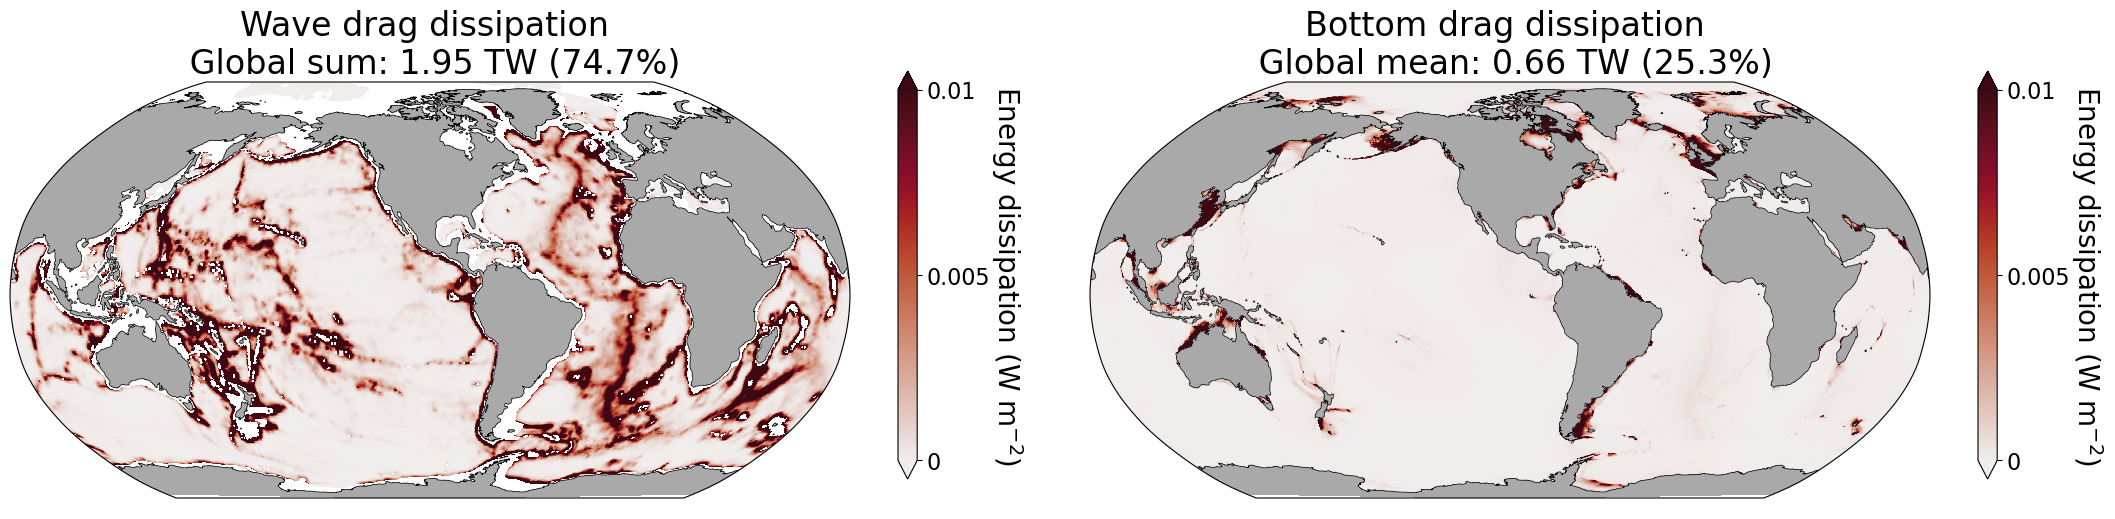

In [13]:
varlist = ['dissip_wave','dissip_bot']
title   = ['Wave drag dissipation \n Global sum: %.2f TW (%.1f%%)'%(global_wave,perc_wave*100), \
           'Bottom drag dissipation \n Global mean: %.2f TW (%.1f%%)'%(global_bot,perc_bot*100)]
# tick_locs = np.array([1e-4,1e-3,1e-2])
# tick_labels = np.array(["10$^{-4}$","10$^{-3}$","10$^{-2}$"])
tick_locs = np.array([0,0.005,0.01])
tick_labels = np.array(["0","0.005","0.01"])

fig = plt.figure(figsize=(24, 6))
axs = []

gridsubs = gridspec.GridSpec(1,2)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

    p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.amp, vmin=0, vmax=0.01)
    # p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-4, vmax=1e-2))
    plt.title(title[I],fontsize=24)
  
    if I==0:
        ax_cb = plt.axes([0.47, 0.16, 0.008, 0.68])
    if I==1:
        ax_cb = plt.axes([0.92, 0.16, 0.008, 0.68])  
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy dissipation (W m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    if I==0:
        ax.set_position([0.1,0.1,0.35,0.75])
    if I==1:
        ax.set_position([0.55,0.1,0.35,0.75])
        
plt.savefig('/g/data/nm03/lxy581/exps_figs/MOM6_JSL_masked_x8_bot_003_quad_M2_dissip_lin.png', dpi=300, bbox_inches='tight')